In [4]:
import numpy as np
import itertools as it
import zarr
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import pandas as pd
from scipy.spatial.distance import squareform, pdist
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.3.5


## Genetic differentiation and diversity within and between NZ and SA Mh
The purpose of this notebook is to calculate how differentiated the South American and New Zealand mh samples are. This is to work out how much divergence has taken place between them since Mh was reared and released into NZ, as well as to work out how diverse both population are.

Start by loading variants and metadata:

In [5]:
zarr_path = '/Users/dennistpw/Library/Mobile Documents/com~apple~CloudDocs/Projects/microctonus/microctonus_genom/snpdata/microctonus_fullcohort_filtered.zarr/'
callset = zarr.open_group(zarr_path, mode='r')
variants = allel.VariantChunkedTable(callset['variants'], 
                                     names=['CHROM','POS', 'REF', 'ALT', 'DP', 'MQ', 'QD', 'QUAL', 'MQRankSum', 'ReadPosRankSum', 'FS', 'SOR' ,'AF'])

df_samples = pd.read_csv('/Users/dennistpw/Library/Mobile Documents/com~apple~CloudDocs/Projects/microctonus/microctonus_genom/sampledata/myhponly_metadata.csv', index_col = 'order')

I'm sure there's a more elegant way of doing this but...make a dictionary of all the subpopulations we want to eventually analyse, and remove subpops with a small sample size (<10 usually)

In [6]:
subpops = {
    'all': list(range(len(df_samples))),
    'Ascasubi': df_samples[df_samples.Site == 'Ascasubi'].index.tolist(),
    'Bariloche': df_samples[df_samples.Site == 'Bariloche'].index.tolist(),
    'Featherston': df_samples[df_samples.Site == 'Featherston'].index.tolist(),
    'Fortrose': df_samples[df_samples.Site == 'Fortrose'].index.tolist(),
    'Hawkes_Bay': df_samples[df_samples.Site == 'Hawkes_Bay'].index.tolist(),
    'La_Serena': df_samples[df_samples.Site == 'La_Serena'].index.tolist(),
    'Lincoln': df_samples[df_samples.Site == 'Lincoln'].index.tolist(),
    'Mararoa': df_samples[df_samples.Site == 'Mararoa'].index.tolist(),
    'Mendoza': df_samples[df_samples.Site == 'Mendoza'].index.tolist(),
    'Mossburn': df_samples[df_samples.Site == 'Mossburn'].index.tolist(),
    'Porto_Alegre': df_samples[df_samples.Site == 'Porto_Alegre'].index.tolist(),
    'Rio_Negro': df_samples[df_samples.Site == 'Rio_Negro'].index.tolist(),
    'Ruakaka': df_samples[df_samples.Site == 'Ruakaka'].index.tolist(),
    'Ruakura': df_samples[df_samples.Site == 'Ruakura'].index.tolist(),
    'Concepcion': df_samples[df_samples.Site == 'Concepcion'].index.tolist(),
    'Colonia': df_samples[df_samples.Site == 'Colonia'].index.tolist(),
    'Greymouth': df_samples[df_samples.Site == 'Greymouth'].index.tolist(),
    'South_America': df_samples[df_samples.Region == 'South_America'].index.tolist(),
    'New_Zealand': df_samples[df_samples.Region == 'New_Zealand'].index.tolist(),
}

for key, value in subpops.items():
    #print value
    print(key, len(list(filter(bool, value))))
to_exclude = ['Ascasubi', 'Hawkes_Bay', 'La_Serena', 'Mararoa', 'Mendoza', 'Porto_Alegre', 'Rio_Negro', 'Ruakaka', 'Greymouth']


all 181
Ascasubi 2
Bariloche 11
Featherston 30
Fortrose 25
Hawkes_Bay 4
La_Serena 2
Lincoln 39
Mararoa 1
Mendoza 1
Mossburn 18
Porto_Alegre 3
Rio_Negro 4
Ruakaka 3
Ruakura 14
Concepcion 9
Colonia 11
Greymouth 4
South_America 43
New_Zealand 138


Remove pops < 9 inds (usually <10 but concepcion is marginal - we will keep and treat with caution)

In [7]:
for k in to_exclude:
    subpops.pop(k, None)

Define some functions that we'll use to iterate by chromosome and subpopulation. First, to make a manhattan line plot of fst over the chromosome (windows of 50 snps):

In [8]:
def plot_fst(ac1, ac2, pos, chrom, blen=50):
    
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=blen)
    
    # use the per-block average Fst as the Y coordinate
    y = vb
    
    # use the block centres as the X coordinate
    x = allel.moving_statistic(pos, statistic=lambda v: (v[0] + v[-1]) / 2, size=blen)
    # plot
    fig, ax = plt.subplots(figsize=(15, 4))
    sns.despine(ax=ax, offset=5)
    ax.plot(x, y, 'k-', lw=.5)
    ax.set_ylabel('$F_{ST}$')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.set_xlim(0, pos.max())
    plt.title(f"Fst (Hudson) over {chrom}. Average. {fst:.3}, +/- {se:.3}")

Then, a function for taking the allele counts of the two pops for a specific chromosome, and using it to calculate Hudson's fst in blocks over the chromosome, then plot:

In [9]:
def do_fst_scafpop(pop1, pop2, chrom):
    #create boolean mask of vars by chrom
    mask = callset['variants/CHROM'][:]==chrom
    x = allel.GenotypeArray(callset['calldata/GT']) #extract gts
    scafgts = x.compress(mask, axis=0) #extract gts matching scaffold with mask
    acs = scafgts.count_alleles_subpops(subpops) #count alleles by subpop
    pos_all = allel.SortedIndex(variants.compress(mask)['POS']) #get pos corresponding to chr of interest
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:]) #get acs of subpops of interest
    flt = acu.is_segregating() & (acu.max_allele() == 1) #get alleles segregating our two subpops and remove multiallelics
    print('retaining', np.count_nonzero(flt), 'SNPs') #print how many we keep
    pos = pos_all.compress(flt) #filter
    ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2]) #ac of pop1
    ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2]) #ac of pop2
    plot_fst(ac1, ac2, pos, chrom) #call plotting function
    

Now, we'll iterate over the 12 main scaffolds and plot Hudson's fst between them. I chose Hudson's Fst (as opposed to Weir and Cockerham, for example), because it is more robust to differences in sample size (see Bhatia 2013).

retaining 175391 SNPs
retaining 148197 SNPs
retaining 134332 SNPs
retaining 106201 SNPs
retaining 113093 SNPs
retaining 98274 SNPs
retaining 89107 SNPs
retaining 77800 SNPs
retaining 72865 SNPs
retaining 54846 SNPs
retaining 56870 SNPs
retaining 27458 SNPs


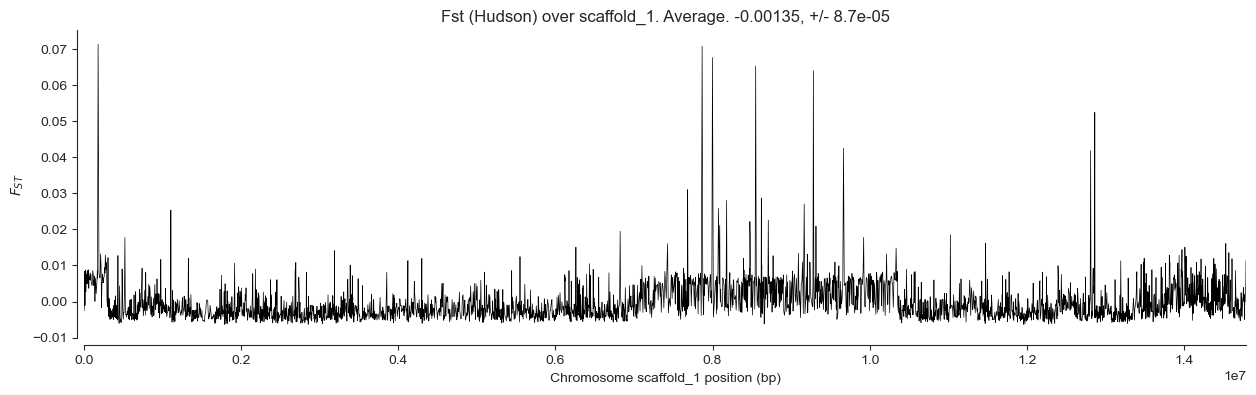

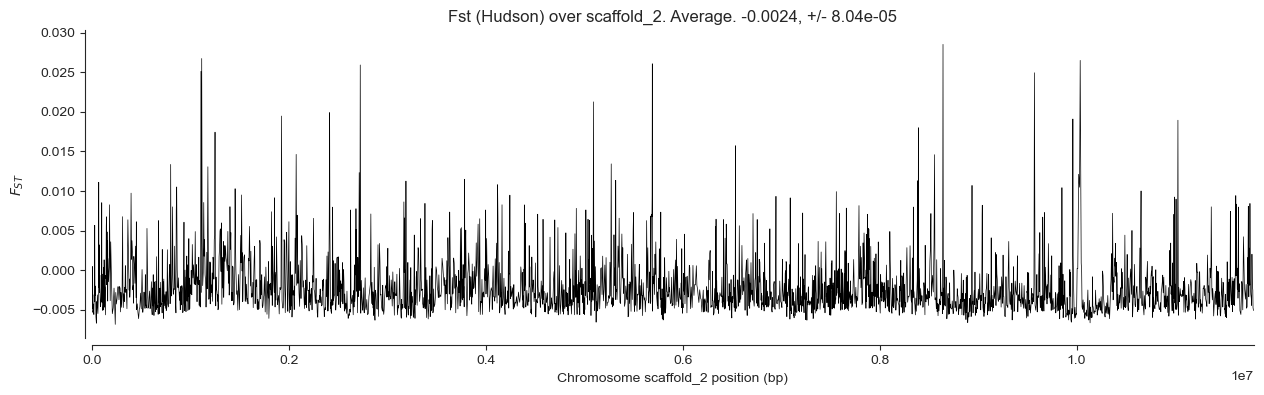

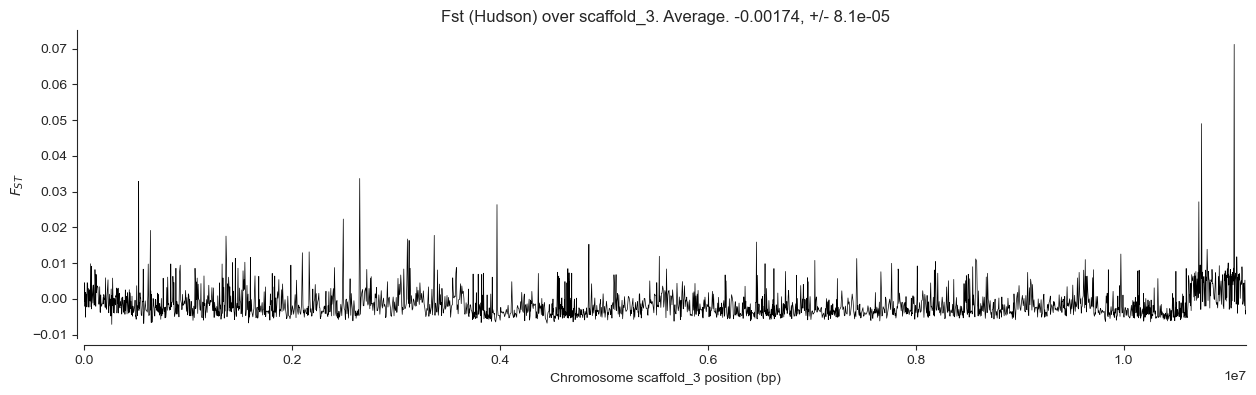

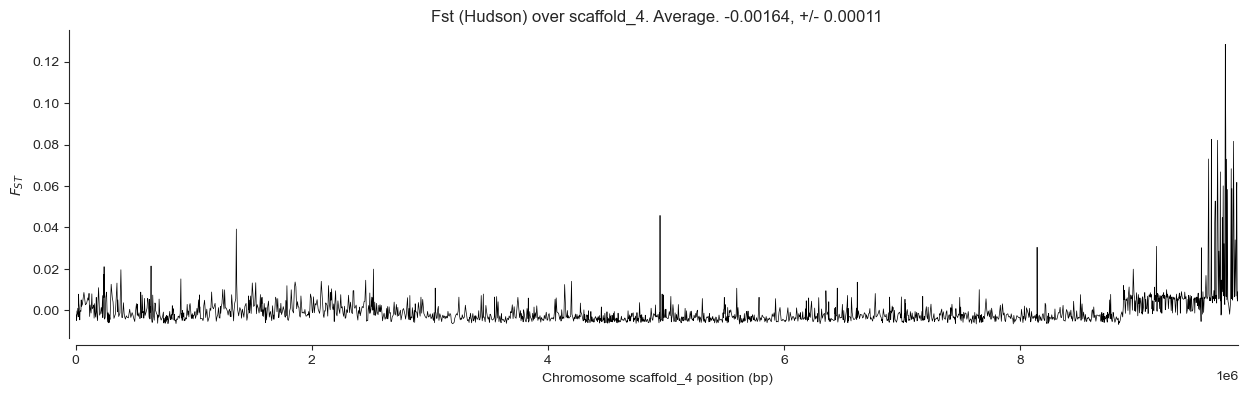

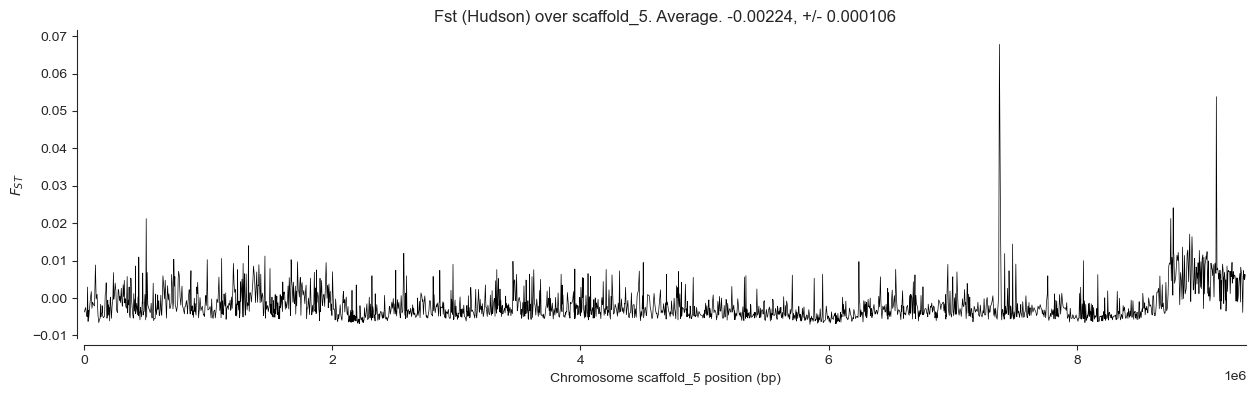

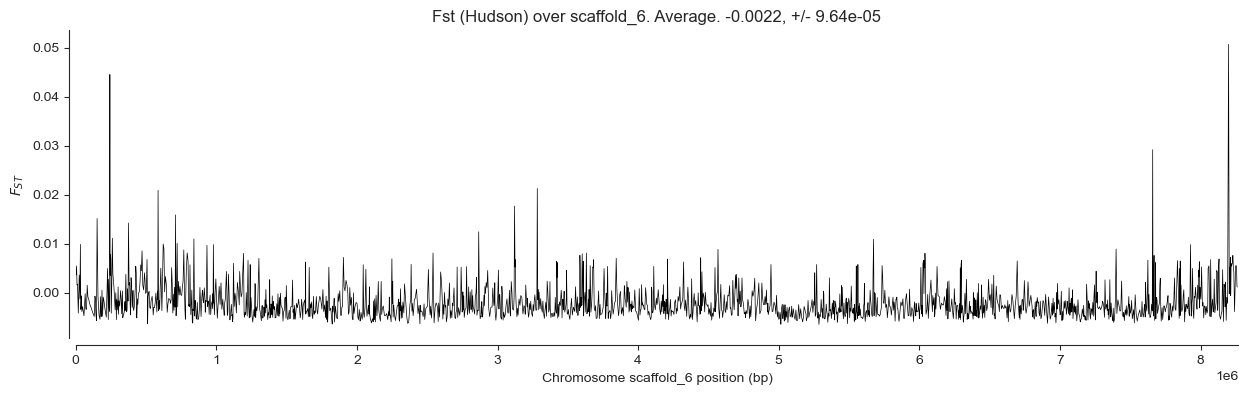

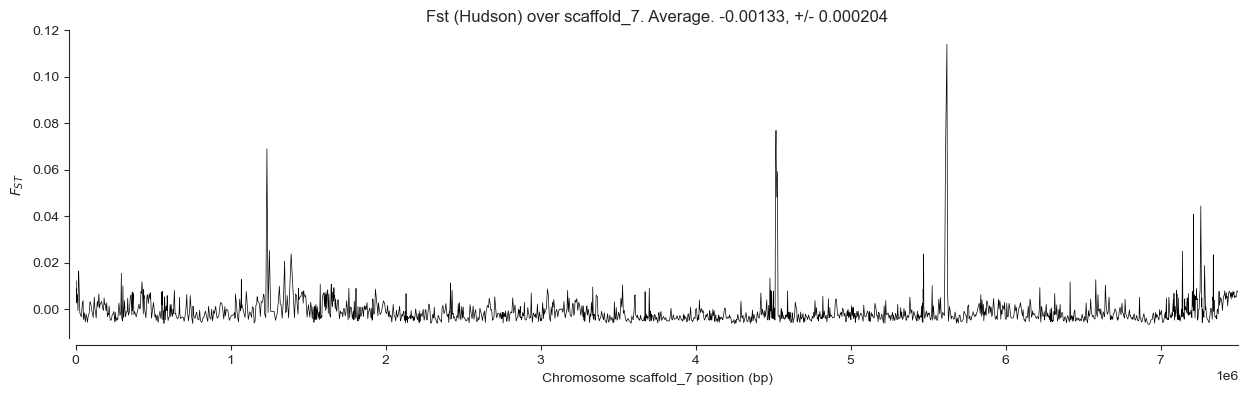

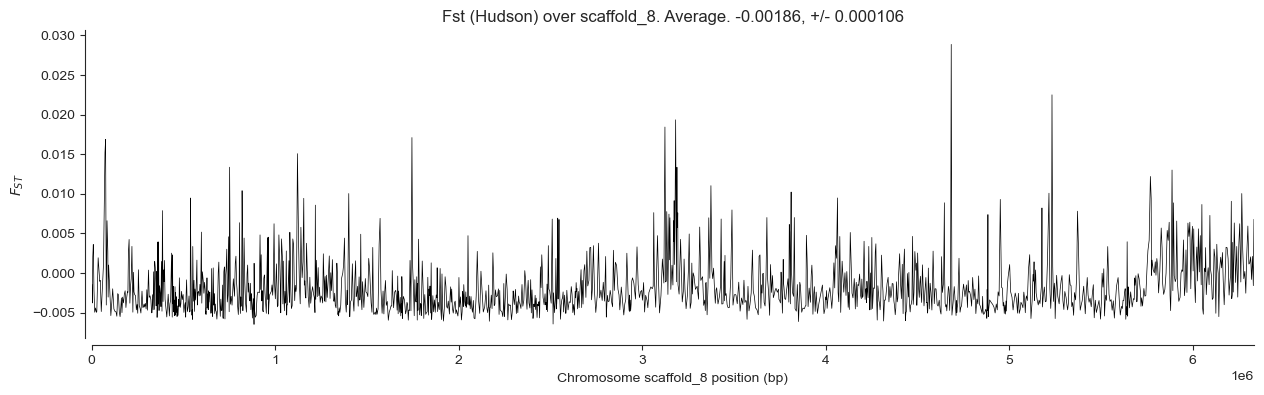

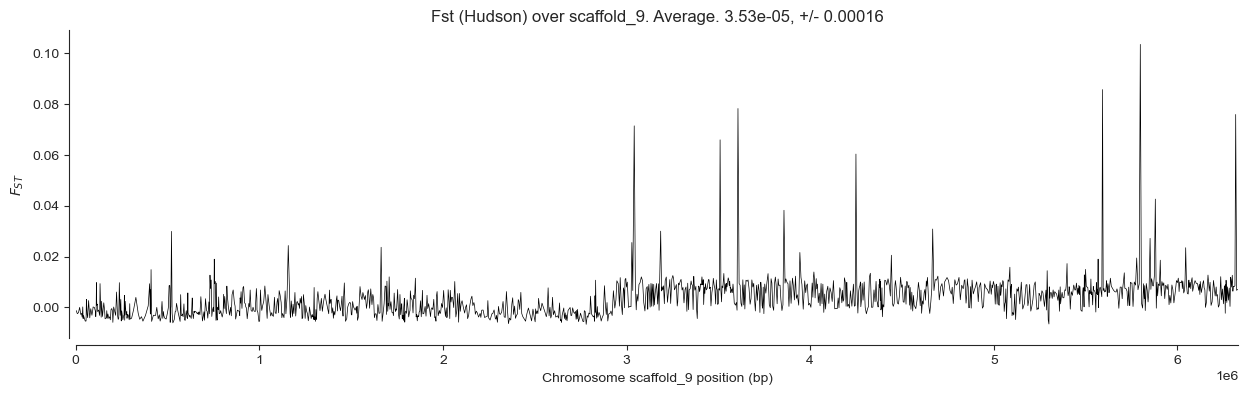

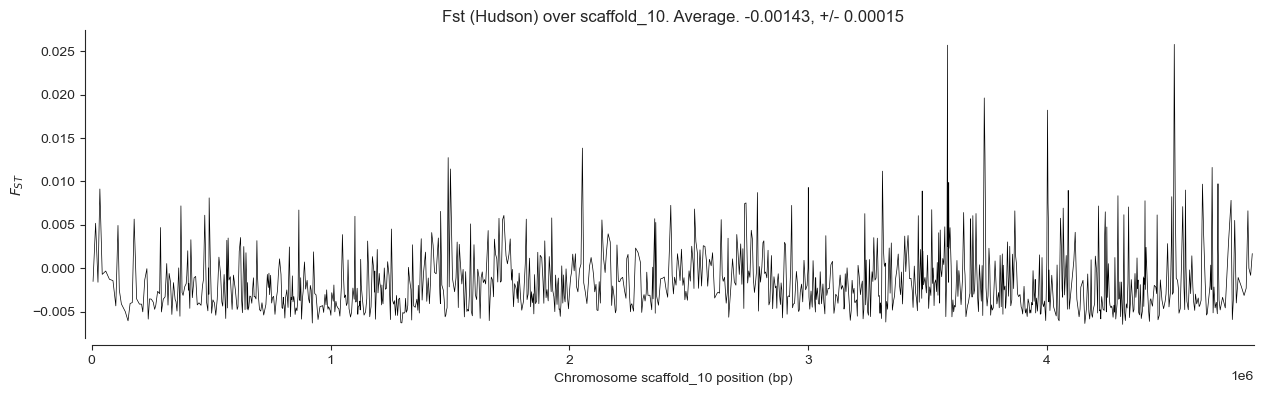

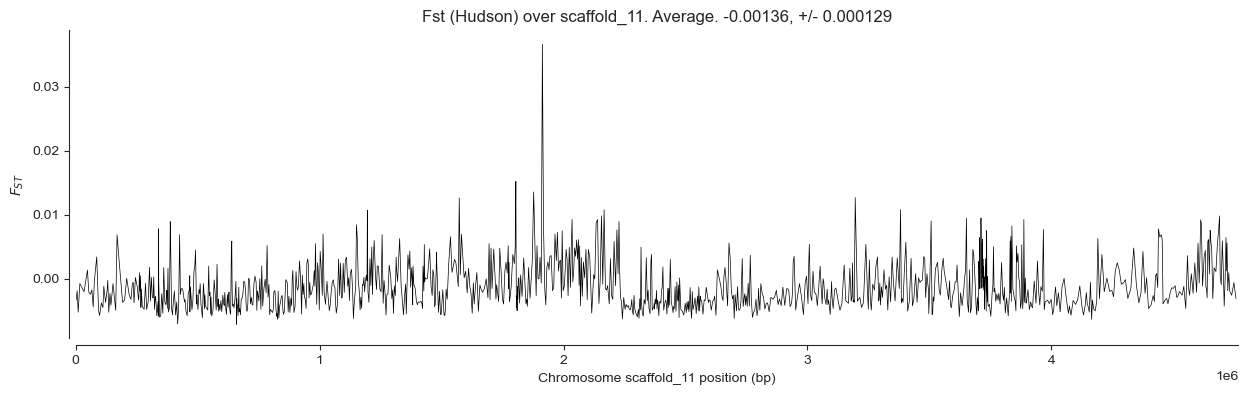

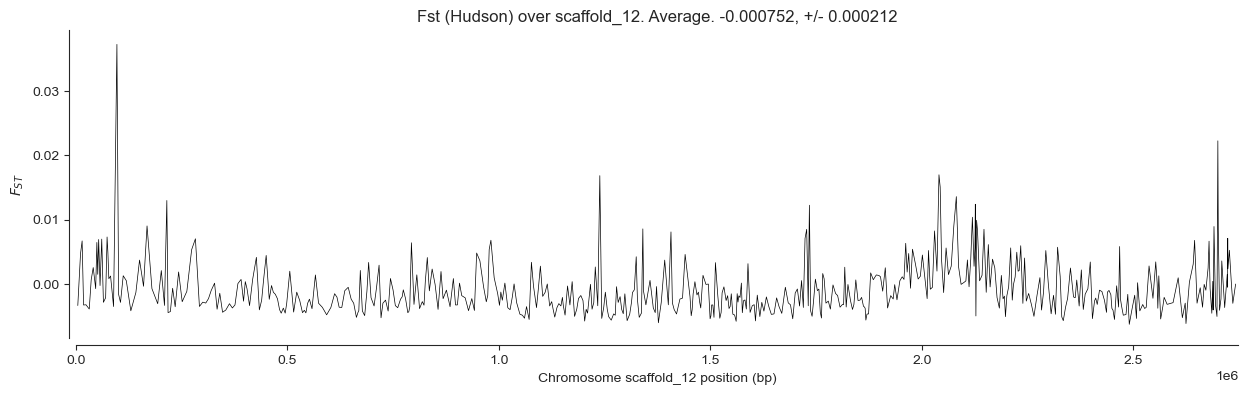

In [7]:
for f in (range(1,13)):
    scaf = 'scaffold_'+str(f)
    do_fst_scafpop('New_Zealand', 'South_America', scaf)

Overall differentiation between NZ and SA is extremely low. Make sure you are looking at the y-scales, which I left free because it lets us look closer at the genome-wide diff (otherwise it would be pointless...).

I so see some blocks of the genome that are more differentiated. Given what we think is true about clonality - this doesn't have to be inversion, but just a chunk of the genome...if that makes sense. Even then, Fst still very low. The existing differentiation is probably due to undersampling in SA (or NZ, but probably more likely SA?). So - not much divergence between them. 

Now, let's have a look to see if there are any sites particularly differentiated, and whether we see any of the three represented SA pops are closer to the remaining NZ pops, just using scaffold_1 this time.

### Site - Region Fst

I'm going to look at individual sites and see the extent to which specific sites are more differentiated from their regional metapopulations - are there genetic outliers? Are there patterns by region?

In [7]:
def do_fst_scafpop_noplot(pop1, pop2):
    #create boolean mask of vars by chrom
    mask = callset['variants/CHROM'][:]=='scaffold_1'
    x = allel.GenotypeArray(callset['calldata/GT']) #extract gts
    scafgts = x.compress(mask, axis=0) #extract gts matching scaffold with mask
    acs = scafgts.count_alleles_subpops(subpops) #count alleles by subpop
    pos_all = allel.SortedIndex(variants.compress(mask)['POS']) #get pos corresponding to chr of interest
    acu = allel.AlleleCountsArray(acs[pop1][:] + acs[pop2][:]) #get acs of subpops of interest
    flt = acu.is_segregating() & (acu.max_allele() == 1) #get alleles segregating our two subpops and remove multiallelics
    pos = pos_all.compress(flt) #filter
    ac1 = allel.AlleleCountsArray(acs[pop1].compress(flt, axis=0)[:, :2]) #ac of pop1
    ac2 = allel.AlleleCountsArray(acs[pop2].compress(flt, axis=0)[:, :2]) #ac of pop2
    fst, se, vb, _ = allel.blockwise_hudson_fst(ac1, ac2, blen=50)
    return(pop1, pop2, fst, se)

Get sitewise fst:

In [10]:
sitewise_fst = []
for f,t in (it.combinations(subpops.keys(),2)):
    x = do_fst_scafpop_noplot(f, t)
    sitewise_fst.append(x)

In [11]:
sitewise_fst_df = pd.DataFrame(sitewise_fst, columns=['pop1', 'pop2', 'hudson_fst', 'se'])

I have had a beer so this is very clunky

In [12]:
all_fst = sitewise_fst_df[(sitewise_fst_df.pop1 == 'New_Zealand') | (sitewise_fst_df.pop1 == 'South_America') | (sitewise_fst_df.pop2 == 'New_Zealand') | (sitewise_fst_df.pop2 == 'South_America')].drop(['se'], axis=1)

In [13]:
all_fst_sq = all_fst.pivot('pop1', 'pop2')

/var/folders/4x/vrllg_b96ll6cgd30x9blq8m0000gn/T/ipykernel_14731/3399404726.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  all_fst_sq = all_fst.pivot('pop1', 'pop2')


Text(0.5, 25.14722222222222, 'Regional Population')

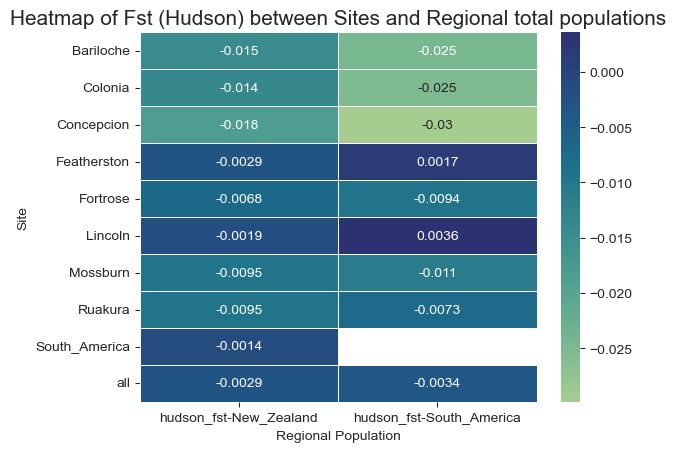

In [14]:
ax = sns.heatmap(all_fst_sq, annot=True, linewidth=.5, cmap="crest")
plt.title('Heatmap of Fst (Hudson) between Sites and Regional total populations', fontsize = 15) # title with fontsize 20
plt.ylabel('Site', fontsize = 10) # x-axis label with fontsize 15
plt.xlabel('Regional Population', fontsize = 10) # y-axis label with fontsize 15

It looks like...samples from within NZ are more similar to one another than NZ:SA samples. SA samples appear to be more different to one another (the samples originate from sites that are very far away from each other) than they are from the NZ sites as a whole. I'll look at this sitewise below:

### Sitewise Fst

Sitewise Fst heatmap. Create df of hudson fst pairwise between sites, drop regions/all comparisons, and pivot into a matrix

In [96]:
sitewise_fstsq = []
for f,t in (it.permutations(subpops.keys(),2)):
    x = do_fst_scafpop_noplot(f, t)
    sitewise_fstsq.append(x)

In [142]:
x = pd.DataFrame(sitewise_fstsq, columns=['pop1', 'pop2', 'hudson_fst', 'se'])
x = x.drop(['se'], axis=1)
sites_fst_new_mat = x.pivot(index='pop1', columns = 'pop2', values='hudson_fst')
sites_fst_new_mat = sites_fst_new_mat.drop(['New_Zealand', 'South_America', 'all'], axis=0)
sites_fst_new_mat = sites_fst_new_mat.drop(['New_Zealand', 'South_America', 'all'], axis=1)

<AxesSubplot: xlabel='pop2', ylabel='pop1'>

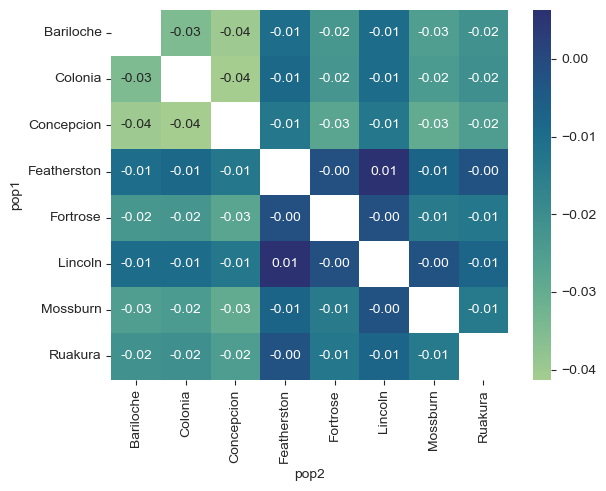

In [156]:
sns.heatmap(sites_fst_new_mat, annot=True, fmt=".2f", cmap="crest")

The South American samples are the least differentiated with respect to all of the sites, and the Fortrose, Mossburn and Ruakara samples seem to be more similar both to each other, and to he SA samples. The sites do seem to form groups by region of origin. The two relative outliers, most differentiated, Featherston and Lincoln, happen to be the original sample set sequenced to a lower coverage. If these are excluded, the SA:NZ distinction remains but everything within each region is basically the same...

## Thetas - Pi, D, theta, by population genomewide and avg: - IN PROGRESS

In [152]:
pilist = []
def do_pi_scafpop(pop, chrom, blen):
    #create boolean mask of vars by chrom
    mask = callset['variants/CHROM'][:]==chrom
    x = allel.GenotypeArray(callset['calldata/GT']) #extract gts
    scafgts = x.compress(mask, axis=0) #extract gts matching scaffold with mask
    acs = scafgts.count_alleles_subpops(subpops) #count alleles by subpop
    pos_all = allel.SortedIndex(variants.compress(mask)['POS']) #get pos corresponding to chr of interest
    ac1 = allel.AlleleCountsArray(acs[pop][:, :2]) #ac of pop1
    pi, windows, n_bases, counts = allel.windowed_diversity(ac=ac1, size=5000, pos=pos_all)
    pidf = pd.DataFrame()
    pidf['pi'] = pi
    pidf['pos'] =windows[:,1].tolist()
    pidf['scaffold'] = chrom
    pidf['pop'] = pop
    pilist.append(pidf)

In [128]:
for f in (range(1,13)):
    scaf = 'scaffold_'+str(f)
    do_pi_scafpop('New_Zealand', scaf, 1000)
concatpilist = pd.concat(pilist)


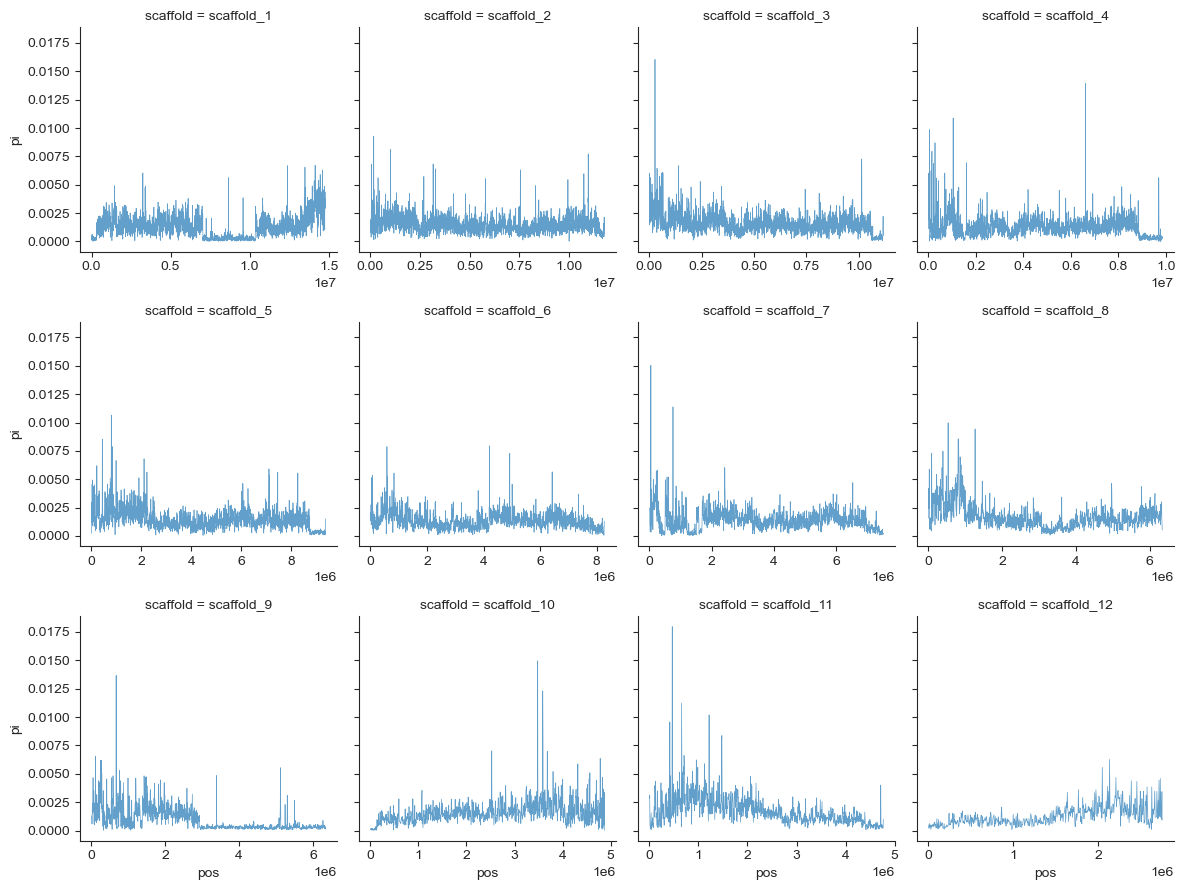

In [141]:
g = sns.FacetGrid(concatpilist,col='scaffold', sharey=True, sharex=False, col_wrap=4)
g.map(sns.lineplot, "pos", "pi", alpha=.7, linewidth=0.5)
ax.spines['left'].set_visible(False)

In [153]:
pilist = []
for f in (range(1,13)):
    scaf = 'scaffold_'+str(f)
    do_pi_scafpop('South_America', scaf, 1000)
concatpilist = pd.concat(pilist)


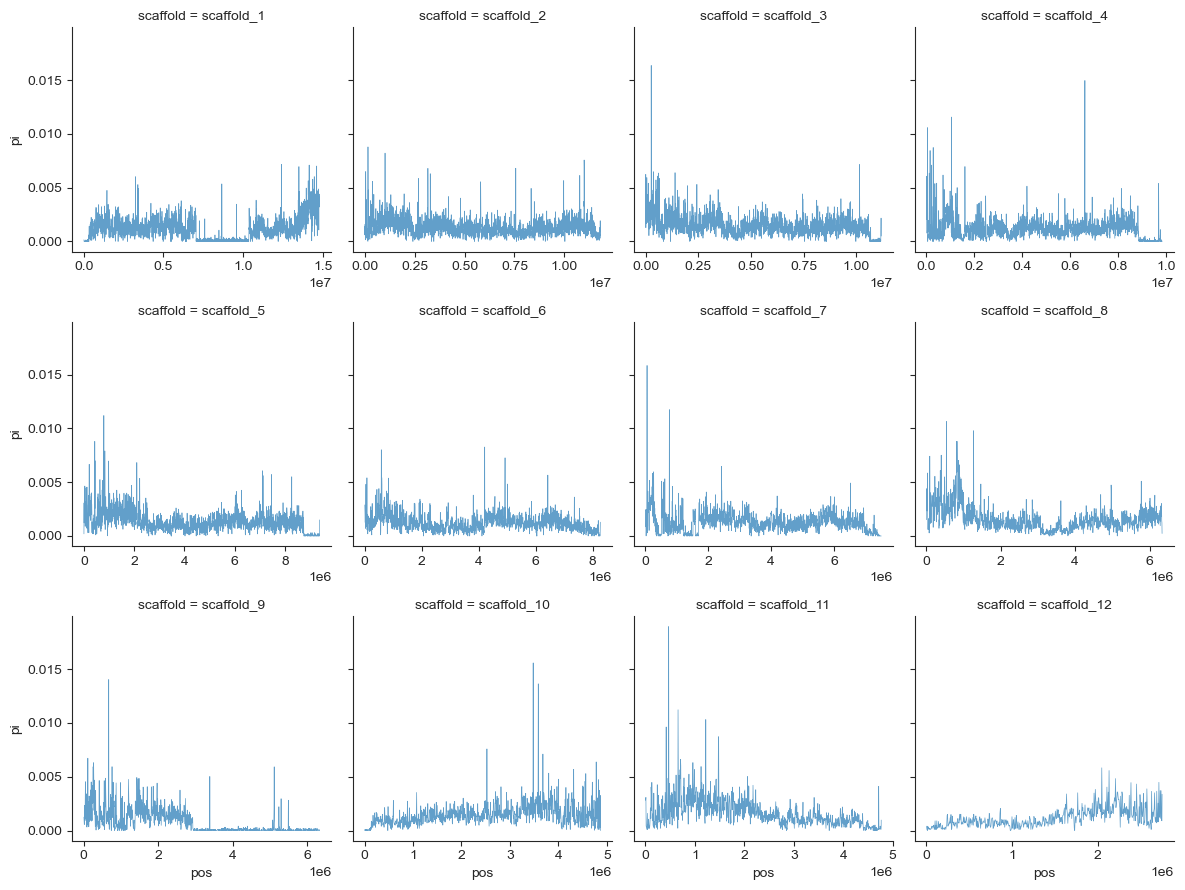

In [146]:
g = sns.FacetGrid(concatpilist,col='scaffold', sharey=True, sharex=False, col_wrap=4)
g.map(sns.lineplot, "pos", "pi", alpha=.7, linewidth=0.5)
ax.spines['left'].set_visible(False)

In [148]:
pilist = []

,pi,pos,scaffold,pop
0,0.000154,5463,scaffold_1,South_America
1,0.000110,10463,scaffold_1,South_America
2,0.000094,15463,scaffold_1,South_America
3,0.000000,20463,scaffold_1,South_America
4,0.000059,25463,scaffold_1,South_America
...,...,...,...,...
545,0.001123,2730669,scaffold_12,South_America
546,0.003701,2735669,scaffold_12,South_America
547,0.000966,2740669,scaffold_12,South_America
548,0.000906,2745669,scaffold_12,South_America


## Conclusions 

##Conclusions



Next steps...
- Thetas (diversity) by region and site